In [67]:
import pandas as pd
import numpy as np
from sklearn.cluster import SpectralClustering, SpectralBiclustering, SpectralCoclustering
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

import sys
sys.path.insert(0, "..")   
from src.gdkm import compute_gdkm_cv_scores, suggest_optimal_pq, GeneralizedDoubleKMeans, generalized_double_kmeans
from src.plot_util import visualize_gdkm_cv_scores, plot_gdkm_elbow_curve, plot_spectral_clustering_elbows , plot_heatmap_with_cluster_boundaries
from src.utils import preprocess_sales_matrix, compute_spectral_clustering_cv_scores, generate_store_item_clusters, reorder_data



In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-06-19'

In [70]:
# load
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }
df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)
cols = ['date', 'store_item', 'store_nbr', 'item_nbr'] + [c for c in df.columns 
                                  if c not in ('date', 'store_item', 'store_nbr', 'item_nbr')]
df = df[cols]
df.rename(columns={"store_nbr": "store", "item_nbr": "item"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)


/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_58358/3612587674.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)


,date,store_item,store,item,unit_sales,onpromotion
0,2013-01-07,48_502331,48,502331,70.00000,NaN
1,2013-01-07,46_584028,46,584028,304.27301,NaN
2,2013-01-07,3_114790,3,114790,28.00000,NaN
3,2013-01-07,3_305229,3,305229,89.00000,NaN
4,2013-01-07,3_314384,3,314384,106.00000,NaN


In [71]:
df['onpromotion'].unique()

array([nan, False, True], dtype=object)

In [72]:
df.head()

,date,store_item,store,item,unit_sales,onpromotion
0,2013-01-07,48_502331,48,502331,70.00000,NaN
1,2013-01-07,46_584028,46,584028,304.27301,NaN
2,2013-01-07,3_114790,3,114790,28.00000,NaN
3,2013-01-07,3_305229,3,305229,89.00000,NaN
4,2013-01-07,3_314384,3,314384,106.00000,NaN


In [73]:
dfs = df.query("date == '2013-01-07'")
print(dfs["item"].nunique())
print(dfs["store"].nunique())

10
10


/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_58358/1364115267.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfs = df.query("date == '2013-01-07'")


In [74]:
store_item_matrix = dfs.pivot_table(
    index='store',
    columns='item',
    values='unit_sales'
)

store_item_matrix = store_item_matrix.fillna(0)
store_item_matrix

item,114790,305229,314384,364606,502331,567623,581078,582864,584028,1047679
store,,,,,,,,,,
3,28.0,89.0,106.0,125.0,96.0,30.0,18.0,91.896004,124.778000,578.0
8,8.0,30.0,37.0,87.0,52.0,15.0,6.0,43.016998,84.625999,307.0
44,26.0,56.0,83.0,145.0,127.0,49.0,62.0,52.875999,199.151993,541.0
45,36.0,42.0,116.0,117.0,116.0,40.0,31.0,94.124001,315.908997,443.0
46,37.0,28.0,108.0,119.0,85.0,35.0,26.0,214.716003,304.273010,88.0
47,24.0,83.0,90.0,137.0,110.0,25.0,33.0,49.745998,138.423996,69.0
48,23.0,51.0,55.0,91.0,70.0,25.0,16.0,63.675999,307.201996,24.0
49,13.0,25.0,34.0,75.0,59.0,27.0,12.0,25.562000,60.768002,15.0
50,33.0,25.0,93.0,128.0,116.0,11.0,82.0,106.417999,278.131012,10.0


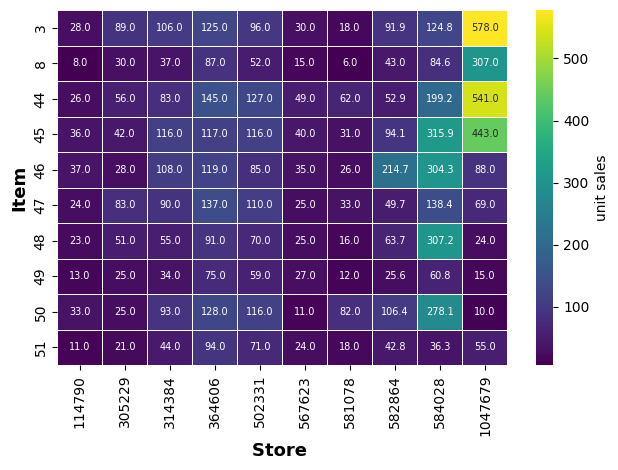

In [75]:
ax = sns.heatmap(
    store_item_matrix,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
    cbar_kws={"label": "unit sales"},
    annot=True,            # show values
    fmt=".1f",             # format to one decimal place
    annot_kws={"fontsize": 7}  # optional: smaller font for clarity
)
ax.set_xlabel("Store ", fontsize=13, fontweight="bold")
ax.set_ylabel("Item", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()
matrix_log = np.log1p(store_item_matrix)
# Normalize each store’s sales profile across items
matrix_norm = matrix_log.apply(zscore, axis=1)  # axis=1

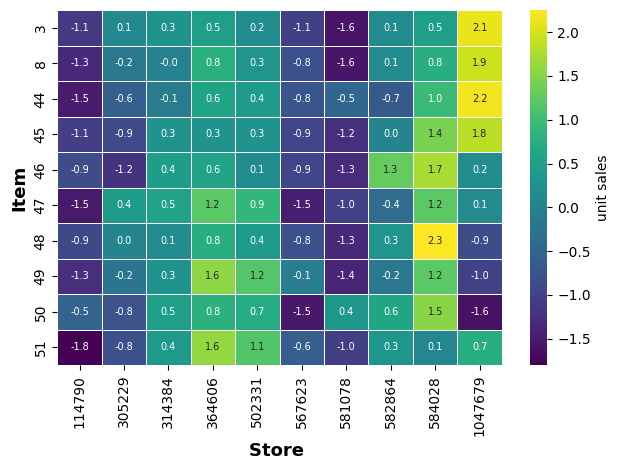

In [76]:
ax = sns.heatmap(
    matrix_norm,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
    cbar_kws={"label": "unit sales"},
    annot=True,            # show values
    fmt=".1f",             # format to one decimal place
    annot_kws={"fontsize": 7}  # optional: smaller font for clarity
)
ax.set_xlabel("Store ", fontsize=13, fontweight="bold")
ax.set_ylabel("Item", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

In [79]:
sc_model = SpectralBiclustering(n_clusters=5, random_state=0)
sc_model.fit(matrix_norm)
# Get reordered indices
row_order = np.argsort(sc_model.row_labels_)
col_order = np.argsort(sc_model.column_labels_)

# Reorder the matrix
matrix_ordered = matrix_norm.iloc[row_order, col_order]


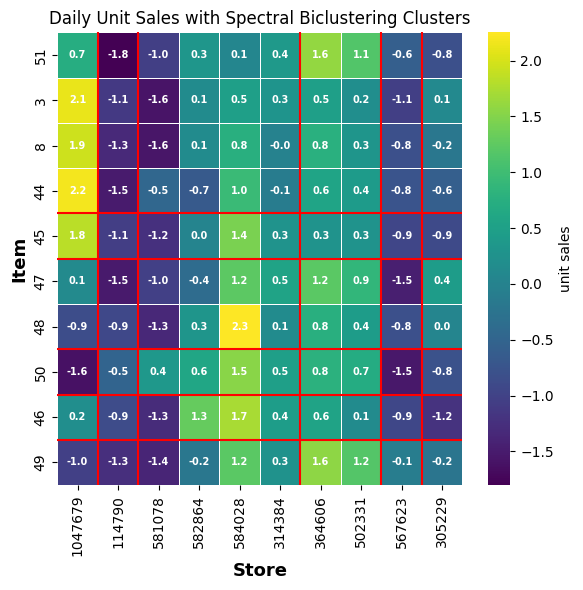

In [82]:
title = "Daily Unit Sales with Spectral Biclustering Clusters"
fn = "../output/figures/20250619_daily_unit_sales_spectral_biclustering.tiff"
plot_heatmap_with_cluster_boundaries(title, matrix_ordered, sc_model.row_labels_, 
                                     sc_model.column_labels_, label_in_cell=False, fn=fn)

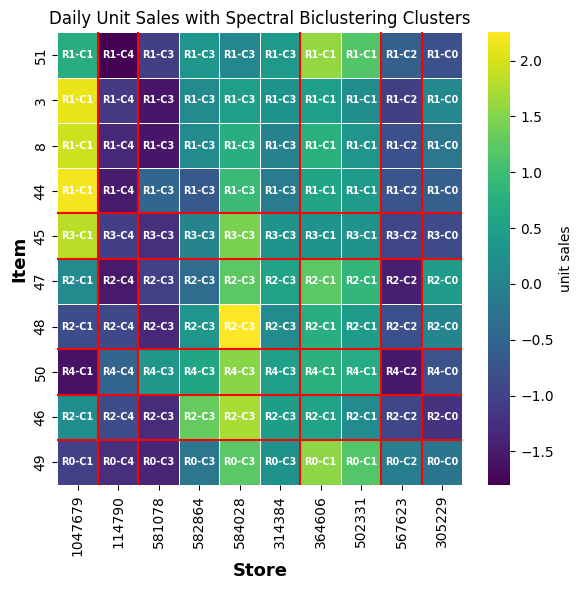

In [84]:
title = "Daily Unit Sales with Spectral Biclustering Clusters"
plot_heatmap_with_cluster_boundaries(title,
                                     matrix_ordered, sc_model.row_labels_, sc_model.column_labels_, label_in_cell=True)

In [93]:
gdkm_model = GeneralizedDoubleKMeans(
        n_row_clusters=3,
        n_col_clusters_list=[2]*3,
        max_iter=100,
        tol=1e-4,
        random_state=0,
        norm="huber"
    )
gdkm_model.fit(matrix_norm.values)

Iteration 0: Loss=3.05e+01, max X=2.253326416015625, max cp=0.17922366676586016
Iteration 1: Loss=2.18e+01, max X=2.253326416015625, max cp=1.0508570075035095
Iteration 2: Loss=1.83e+01, max X=2.253326416015625, max cp=1.5584863424301147
Iteration 3: Loss=1.72e+01, max X=2.253326416015625, max cp=1.6334890127182007
Iteration 4: Loss=1.71e+01, max X=2.253326416015625, max cp=1.5653620958328247
Iteration 5: Loss=1.71e+01, max X=2.253326416015625, max cp=1.5653620958328247
Converged at iteration 5


GeneralizedDoubleKMeans(n_col_clusters_list=[2, 2, 2], norm='huber',
                        random_state=0)

In [94]:
row_order = np.argsort(gdkm_model.row_labels_)
col_order = np.argsort(gdkm_model.column_labels_)
# Reorder the matrix
matrix_ordered = matrix_norm.iloc[row_order, col_order]

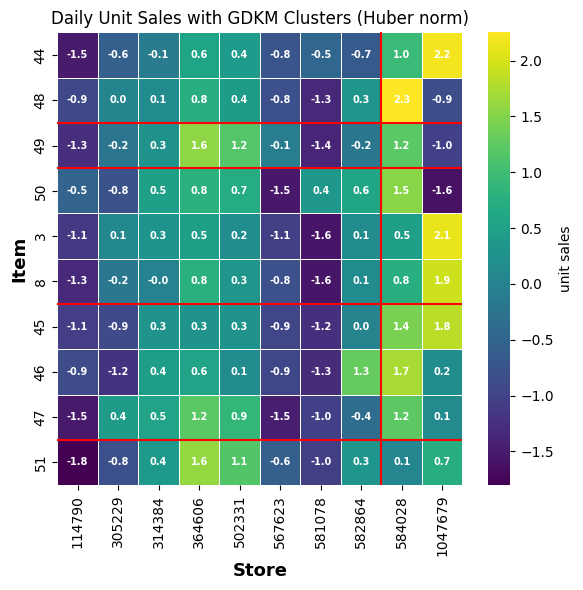

In [95]:
title = "Daily Unit Sales with GDKM Clusters (Huber norm)"
fn = "../output/figures/20250619_daily_unit_sales_gdkm_huber.tiff"
plot_heatmap_with_cluster_boundaries(title, matrix_ordered, gdkm_model.row_labels_, gdkm_model.column_labels_, fn=fn)

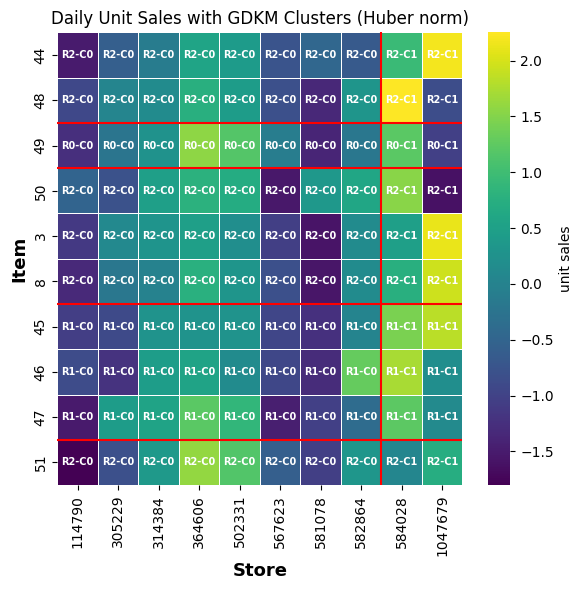

In [96]:
title = "Daily Unit Sales with GDKM Clusters (Huber norm)"
fn = "../output/figures/20250619_daily_unit_sales_gdkm_huber_with_clusters.tiff"
plot_heatmap_with_cluster_boundaries(title, matrix_ordered, gdkm_model.row_labels_, gdkm_model.column_labels_, 
                                     label_in_cell=True, fn=fn)

In [ ]:
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["weekofyear"] = df["date"].dt.isocalendar().week
df

,date,store_item,store,item,unit_sales,onpromotion,dayofweek,month,weekofyear
0,2013-01-07,48_502331,48,502331,70.00000,NaN,0,1,2
1,2013-01-07,46_584028,46,584028,304.27301,NaN,0,1,2
2,2013-01-07,3_114790,3,114790,28.00000,NaN,0,1,2
3,2013-01-07,3_305229,3,305229,89.00000,NaN,0,1,2
4,2013-01-07,3_314384,3,314384,106.00000,NaN,0,1,2
...,...,...,...,...,...,...,...,...,...
167299,2017-08-15,51_567623,51,567623,17.00000,False,1,8,33
167300,2017-08-15,51_581078,51,581078,30.00000,False,1,8,33
167301,2017-08-15,49_567623,49,567623,29.00000,False,1,8,33
167302,2017-08-15,49_502331,49,502331,61.00000,False,1,8,33


In [6]:
df_weekly = df.groupby([
    pd.Grouper(key='date', freq='W'),
    'store', 'item'
])['unit_sales'].sum().reset_index()
df_weekly.head()

,date,store,item,unit_sales
0,2013-01-13,3,114790,131.0
1,2013-01-13,3,305229,553.0
2,2013-01-13,3,314384,589.0
3,2013-01-13,3,364606,754.0
4,2013-01-13,3,502331,604.0


In [36]:
store_item_matrix = df.pivot_table(
    index='store',
    columns='item',
    values='unit_sales',
    aggfunc='mean'  # or 'sum', 'max', etc.
)

store_item_matrix = store_item_matrix.fillna(0)
store_item_matrix


item,114790,305229,314384,364606,502331,567623,581078,582864,584028,1047679
store,,,,,,,,,,
3,27.108124,63.950417,101.274788,107.482674,75.588409,31.792114,17.258219,71.035988,64.032539,444.109314
8,11.149940,27.755703,55.296295,63.240742,45.220428,18.643156,14.933692,27.518524,47.129799,227.244324
44,34.733692,55.383373,104.248505,112.069977,85.783752,50.167862,50.083782,59.410400,78.856087,495.701324
45,41.463562,49.682796,139.155914,132.439072,71.828552,53.934887,33.095867,84.386185,191.282730,129.111176
46,39.949131,33.993408,106.913879,109.719070,75.030464,39.524551,35.617825,129.463562,207.365662,123.478493
47,36.595810,62.344685,115.031067,119.578598,86.900833,44.974895,34.894863,72.931549,122.660606,191.991638
48,37.768082,33.579201,82.525406,85.804062,77.191757,27.651731,30.169754,83.582352,273.251373,63.222820
49,22.993425,39.906212,70.789726,76.007172,62.272400,31.137396,12.925284,55.208302,73.311699,103.075356
50,32.529942,24.746714,88.255241,105.722221,62.578255,22.468544,49.909691,78.884956,159.557663,23.912029


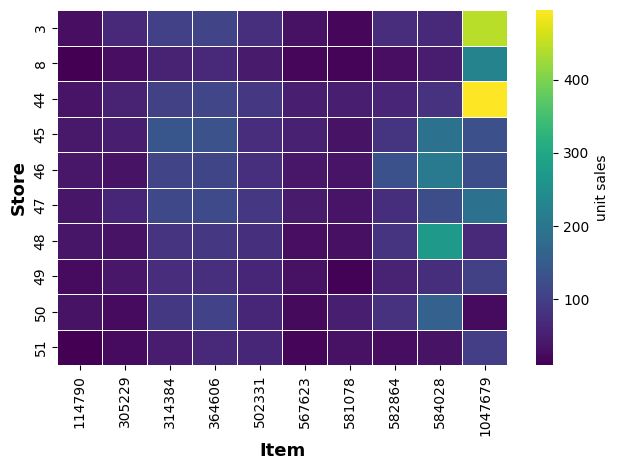

In [37]:
ax = sns.heatmap(
    store_item_matrix,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "unit sales"}
)

#ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Item", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",       fontsize=13, fontweight="bold")

plt.tight_layout()

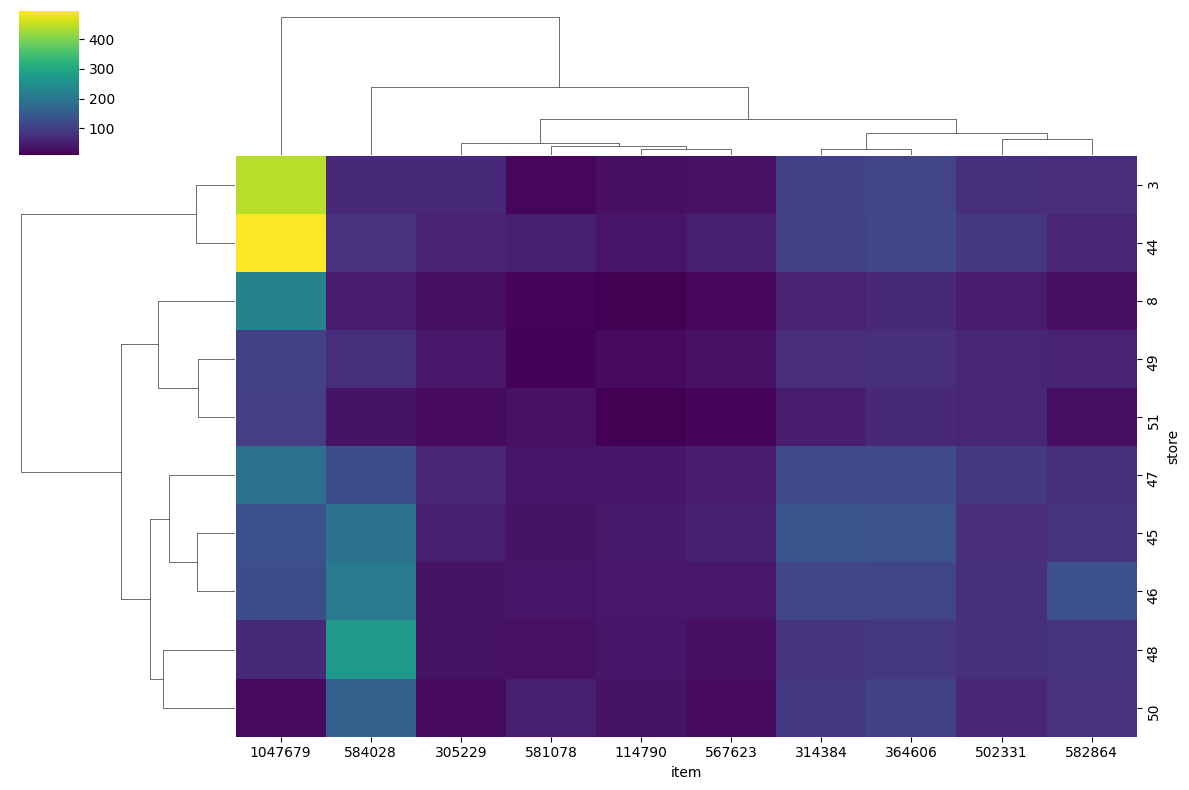

In [38]:
sns.clustermap(store_item_matrix, cmap='viridis', figsize=(12, 8))


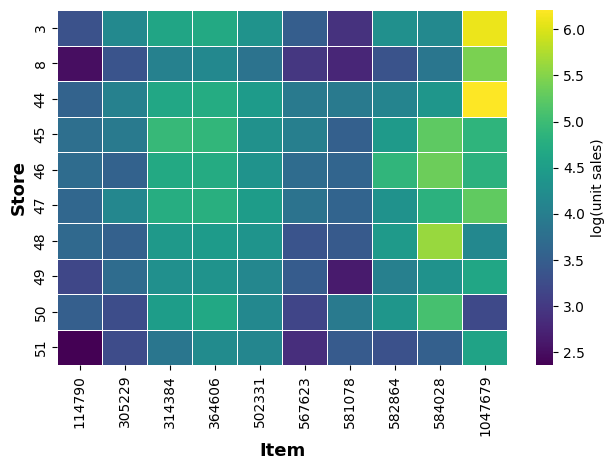

In [39]:
matrix_log = np.log1p(store_item_matrix)
ax = sns.heatmap(
    matrix_log,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(unit sales)"}
)

#ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Item", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",  fontsize=13, fontweight="bold")

plt.tight_layout()


<Axes: xlabel='item', ylabel='store'>

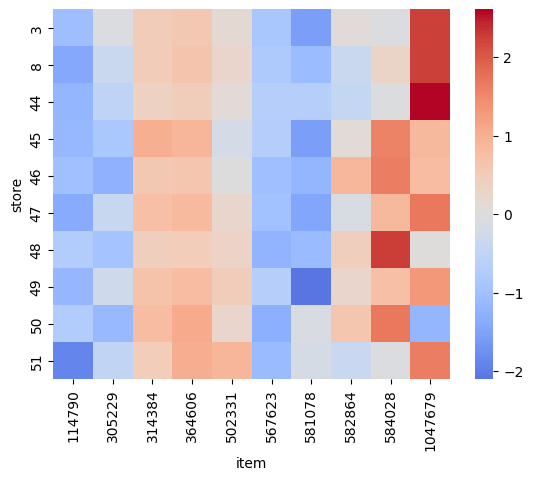

In [40]:
from scipy.stats import zscore

# Normalize each store’s sales profile across items
matrix_norm = matrix_log.apply(zscore, axis=1)  # axis=1 → row-wise
sns.heatmap(matrix_norm, cmap='coolwarm', center=0)

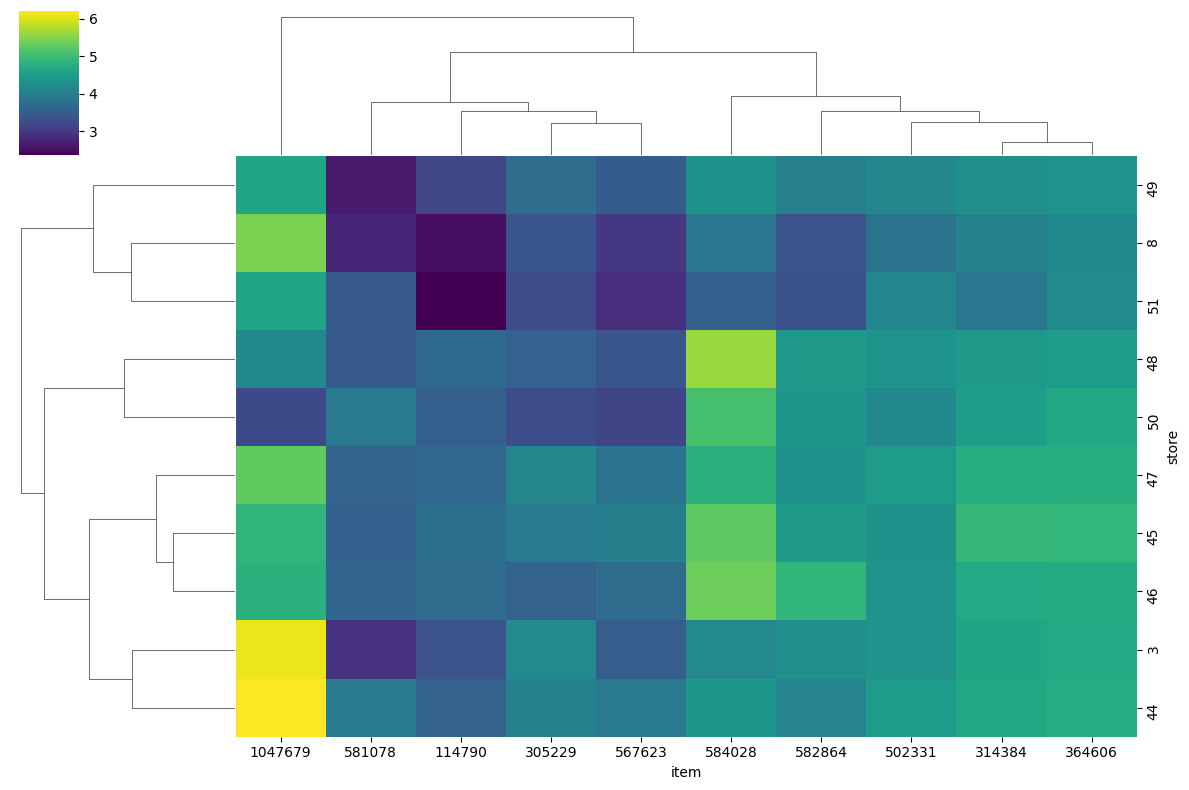

In [41]:
sns.clustermap(matrix_log, cmap='viridis', figsize=(12, 8))


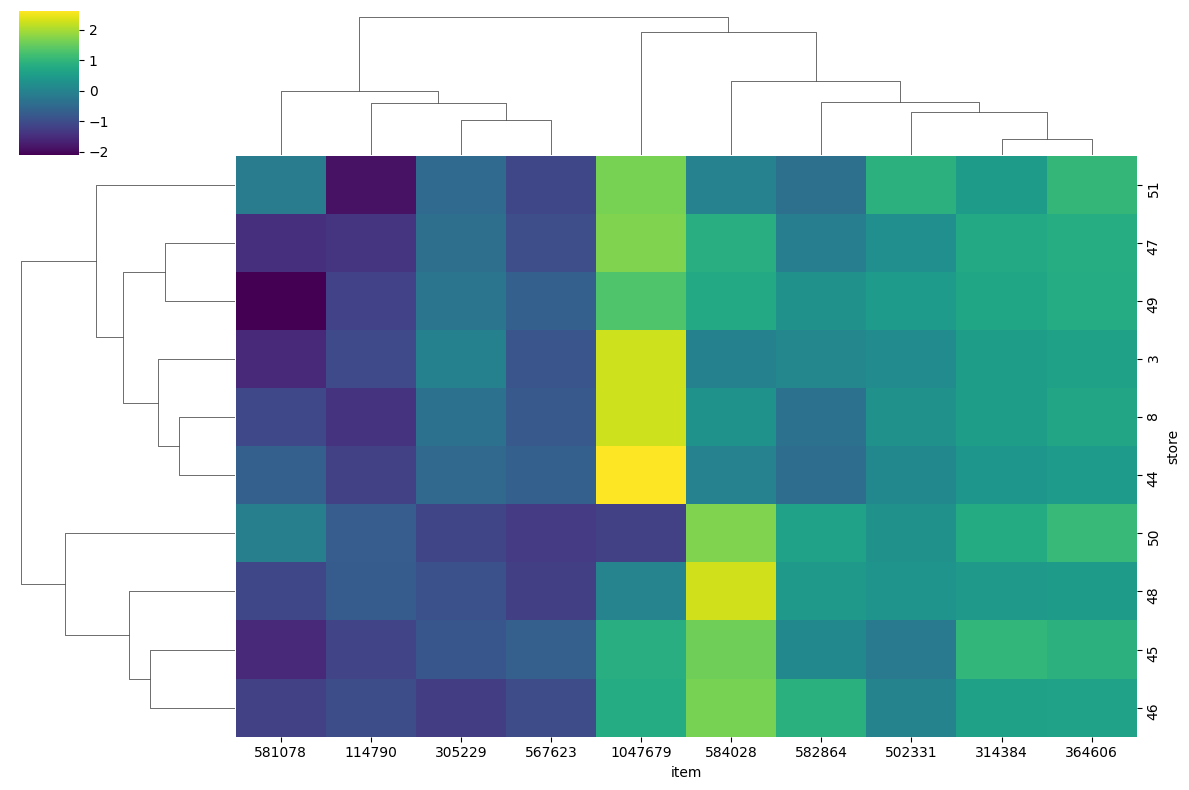

In [42]:
sns.clustermap(matrix_norm, cmap='viridis', figsize=(12, 8))


In [43]:
model = SpectralBiclustering(n_clusters=5, method='log', random_state=0)
model.fit(store_item_matrix)

SpectralBiclustering(method='log', n_clusters=5, random_state=0)

In [44]:
# Get reordered indices
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)

# Reorder the matrix
matrix_ordered = store_item_matrix.iloc[row_order, col_order]

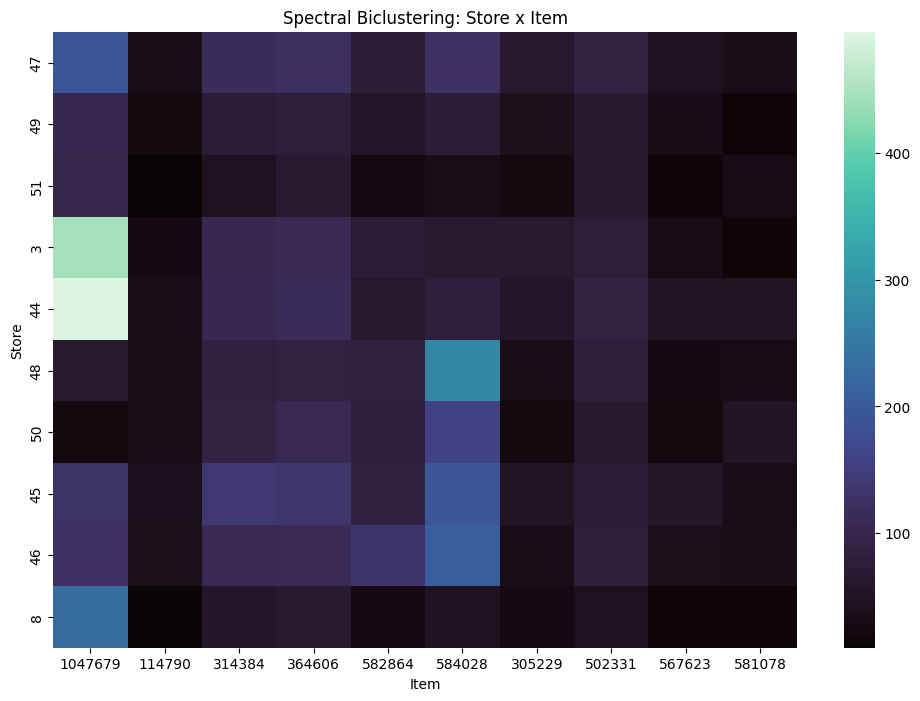

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(matrix_ordered, cmap='mako')
plt.title("Spectral Biclustering: Store x Item")
plt.xlabel("Item")
plt.ylabel("Store")
plt.show()


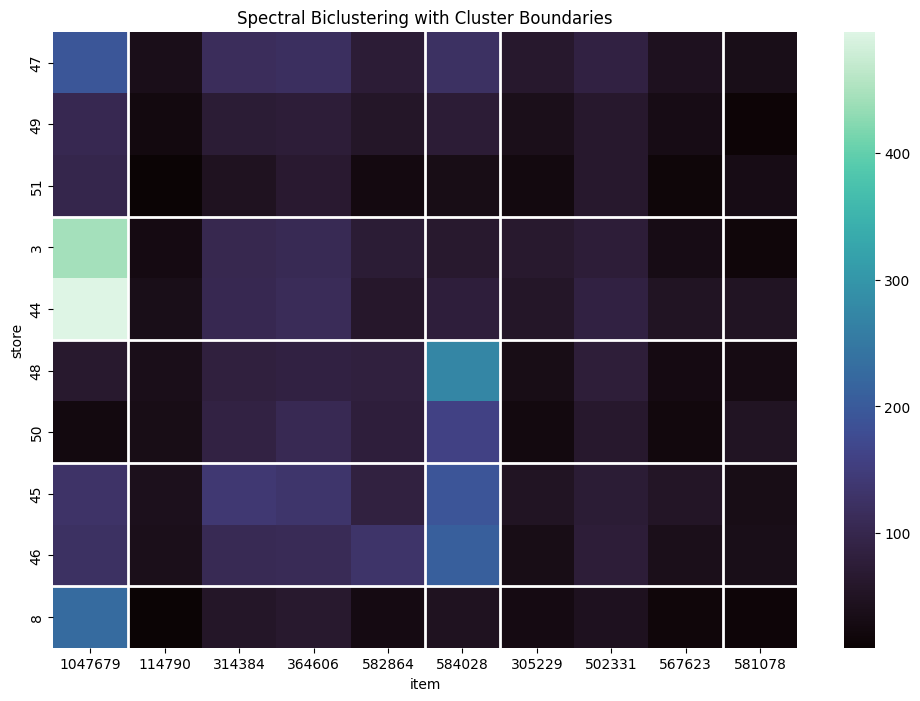

In [46]:
import numpy as np

# Number of row/col clusters
n_row_clusters = len(set(model.row_labels_))
n_col_clusters = len(set(model.column_labels_))

# Row/Col boundaries
row_cuts = [np.where(np.diff(np.sort(model.row_labels_)) != 0)[0] + 1]
col_cuts = [np.where(np.diff(np.sort(model.column_labels_)) != 0)[0] + 1]

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_ordered, cmap='mako', cbar=True)

for r in row_cuts[0]:
    plt.axhline(r, color='white', linewidth=2)
for c in col_cuts[0]:
    plt.axvline(c, color='white', linewidth=2)

plt.title("Spectral Biclustering with Cluster Boundaries")
plt.show()


In [47]:
model = SpectralBiclustering(n_clusters=7, method='log', random_state=0)
model.fit(matrix_norm)

SpectralBiclustering(method='log', n_clusters=7, random_state=0)

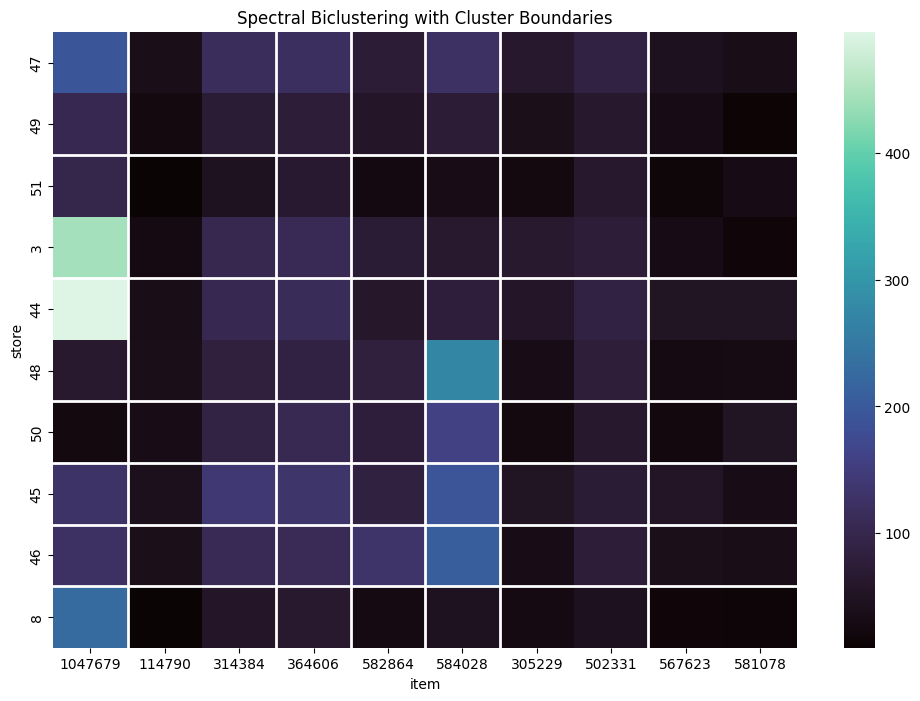

In [48]:
# Number of row/col clusters
n_row_clusters = len(set(model.row_labels_))
n_col_clusters = len(set(model.column_labels_))

# Row/Col boundaries
row_cuts = [np.where(np.diff(np.sort(model.row_labels_)) != 0)[0] + 1]
col_cuts = [np.where(np.diff(np.sort(model.column_labels_)) != 0)[0] + 1]

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_ordered, cmap='mako', cbar=True)

for r in row_cuts[0]:
    plt.axhline(r, color='white', linewidth=2)
for c in col_cuts[0]:
    plt.axvline(c, color='white', linewidth=2)

plt.title("Spectral Biclustering with Cluster Boundaries")
plt.show()

In [58]:
model = GeneralizedDoubleKMeans(n_row_clusters=5, n_col_clusters_list=[5] * 5, random_state=0)
X_np = np.random.poisson(5, (10, 8))  # Placeholder in case store_item_matrix is unavailable here
model.fit(X_np)

ValueError: All column cluster blocks are empty or malformed.

In [62]:
X_debug = np.random.poisson(5, (10, 25))  # 10 stores, 25 items

U_dbg, V_list_dbg, C_blocks_dbg, loss_dbg = generalized_double_kmeans(
    X_debug,
    P=5,
    Q_list=[5] * 5,  # One Qp per row cluster
    max_iter=100,
    tol=1e-4,
    random_state=0
)

[(Vp.shape, Vp.ndim) for Vp in V_list_dbg]


[((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1)]

In [57]:
model = GeneralizedDoubleKMeans(n_row_clusters=5, n_col_clusters_list=[3] * 3, random_state=0)
model.fit(store_item_matrix.values)

IndexError: list index out of range

In [12]:

# Example: aggregate by dayofweek
store_clust_df = df.groupby(["store", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
store_clust_df

KeyError: 'dayofweek'

In [8]:
X, pivot_clean = preprocess_sales_matrix(store_clust_df, log_transform=True, smooth_window=16, zscore_rows=True)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:421: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df = df.rolling(window=smooth_window, axis=1, min_periods=1).mean()


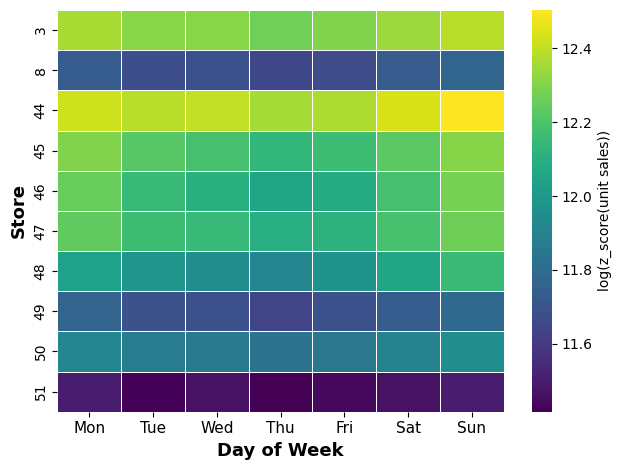

In [9]:

day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
norm = plt.Normalize(vmin=pivot_clean.values.min(),
                     vmax=pivot_clean.values.max())


ax = sns.heatmap(
    pivot_clean,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(z_score(unit sales))"}
)

ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",       fontsize=13, fontweight="bold")

plt.tight_layout()
fn = "../output/figures/2025-06-07_heatmap_store_sales_matrix.tiff"
plt.savefig(fn, dpi=300)
plt.show()
plt.close()



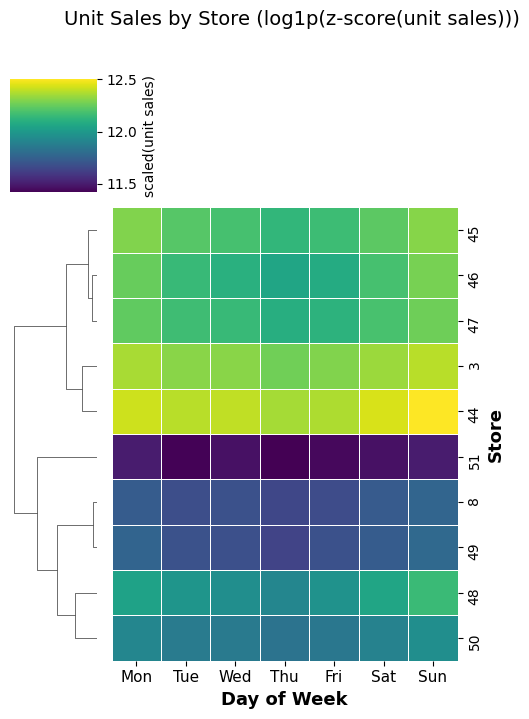

In [19]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# ---------------------------------------------------------------------
# build the clustermap
# ---------------------------------------------------------------------
grid = sns.clustermap(
    pivot_clean,
    cmap="viridis",
    row_cluster=True,
    col_cluster=False,          # keep Mon→Sun order
    linewidths=.4, linecolor="white",
    figsize=(6, 7),
  #      cbar_pos=(0.90, 0.20, 0.03, 0.65),   # [x, y, width, height]
    cbar_kws={
        "label": "scaled(unit sales)",
        "orientation": "vertical",   # just to be explicit
    }
)

# tidy up the heat‑map axis
ax = grid.ax_heatmap
ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week",  fontsize=13, fontweight="bold")
ax.set_ylabel("Store",        fontsize=13, fontweight="bold")

# overall title (use the figure, not the heat‑map axis)
grid.figure.suptitle(
    "Unit Sales by Store (log1p(z‑score(unit sales)))",
    fontsize=14, y=1.02
)

# ---------------------------------------------------------------------
# FIRST let matplotlib tighten up everything *else* …
# ---------------------------------------------------------------------
#grid.figure.tight_layout(rect=[0, 0, 0.88, 1])     # leave room on the right

# ---------------------------------------------------------------------
# … THEN move / resize the colour‑bar
# ---------------------------------------------------------------------

# optional: put tick labels on the outside
#grid.cax.yaxis.set_label_position('right')
grid.cax.yaxis.tick_right()
grid.figure.tight_layout(rect=[0, 0, 0.88, 1])

# ---------------------------------------------------------------------
# save / show
# ---------------------------------------------------------------------
fn = "../output/figures/2025-06-07_clustered_store_sales_matrix.tiff"
grid.figure.savefig(fn, dpi=300    )
plt.show()
plt.close()


In [25]:
results_spectral_clustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(2, 8),
    cv_folds=3
)
results_spectral_clustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-p

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,42.022753,0.541314,NaN
1,3,NaN,58.289140,0.225026,NaN
2,4,NaN,79.633059,0.458693,NaN
3,5,NaN,78.637807,0.458693,NaN
4,6,NaN,83.910748,0.445367,NaN


In [21]:
results_spectral_biclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralBiclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_biclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,63.539831,0.541314,NaN
1,3,NaN,55.149080,0.392015,NaN
2,4,NaN,67.576050,0.392015,NaN
3,5,NaN,75.310768,0.177420,NaN
4,6,NaN,84.248961,0.458693,NaN


In [28]:
results_spectral_coclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralCoclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_coclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,36.404406,0.541314,NaN
1,3,NaN,51.316306,0.541314,NaN
2,4,NaN,52.517374,0.177420,NaN
3,5,NaN,88.013466,0.445367,NaN
4,6,NaN,91.179629,0.445367,NaN


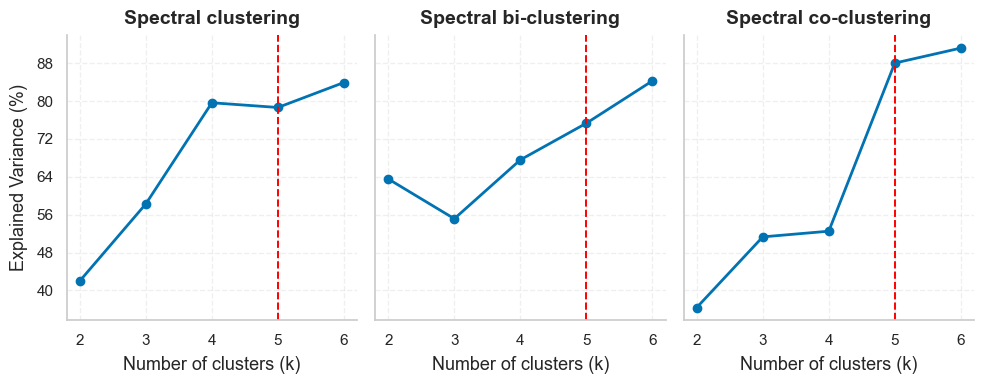

In [35]:
plot_spectral_clustering_elbows([results_spectral_clustering, results_spectral_biclustering, results_spectral_coclustering], 
                                titles=["Spectral clustering", 
                                        "Spectral bi-clustering", 
                                        "Spectral co-clustering"], 
                                vline_x=5,
                                fn="../output/figures/20250610_store_spectral_clustering_elbow.tiff")

In [36]:
store_clusters = generate_store_item_clusters(pivot_clean, n_clusters=5, model_class=SpectralClustering)
store_clusters

,store_item,clusterId
0,3,3
1,8,1
2,44,3
3,45,2
4,46,2
5,47,4
6,48,0
7,49,1
8,50,0
9,51,1


In [52]:
store_clusters.to_excel("../output/data/20250610_store_clusters.xlsx", index=False)


In [39]:
item_clust_df = df.groupby(["item", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
item_clust_df

dayofweek,0,1,2,3,4,5,6
item,,,,,,,
114790,65934.00000,58541.000000,61027.000000,49694.000000,59724.00000,92168.000000,104334.000000
305229,100526.00000,87752.000000,96594.000000,77143.000000,94014.00000,113315.000000,126298.000000
314384,208535.00000,178413.000000,187639.000000,148368.000000,181779.00000,286893.000000,331265.000000
364606,233280.00000,206453.000000,218815.000000,177461.000000,195605.00000,278954.000000,326067.000000
502331,174052.00000,139167.000000,140516.000000,118401.000000,136309.00000,200200.000000,269012.000000
567623,80895.00000,65895.000000,66624.000000,52940.000000,61229.00000,100220.000000,135745.000000
581078,70016.00000,64095.000000,71520.000000,58879.000000,71888.00000,88769.000000,92420.000000
582864,148046.03125,131828.734375,130798.570312,123210.703125,262692.65625,173113.109375,183678.265625
584028,291425.68750,257868.406250,257720.062500,234997.234375,334694.56250,342394.843750,372661.968750


In [40]:
X, pivot_clean = preprocess_sales_matrix(item_clust_df, log_transform=True, smooth_window=16, zscore_rows=True)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:421: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df = df.rolling(window=smooth_window, axis=1, min_periods=1).mean()


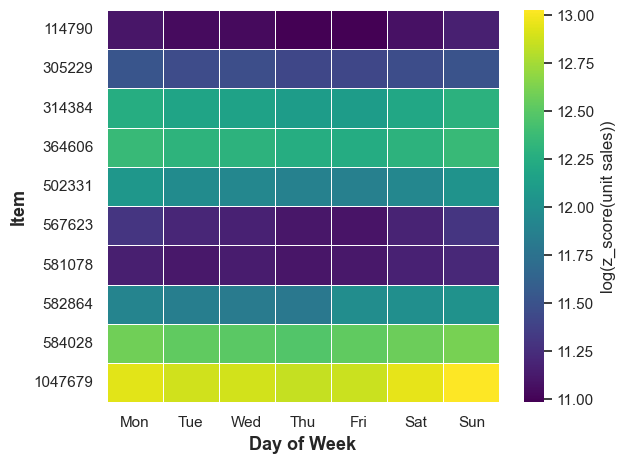

In [41]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
norm = plt.Normalize(vmin=pivot_clean.values.min(),
                     vmax=pivot_clean.values.max())


ax = sns.heatmap(
    pivot_clean,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(z_score(unit sales))"}
)

ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week", fontsize=13, fontweight="bold")
ax.set_ylabel("Item",       fontsize=13, fontweight="bold")

plt.tight_layout()
fn = "../output/figures/20250610_heatmap_item_sales_matrix.tiff"
plt.savefig(fn, dpi=300)
plt.show()
plt.close()

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_17412/3335997768.py:34: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  grid.figure.tight_layout(rect=[0, 0, 0.88, 1])
/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_17412/3335997768.py:40: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  grid.figure.savefig(fn, dpi=300    )
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


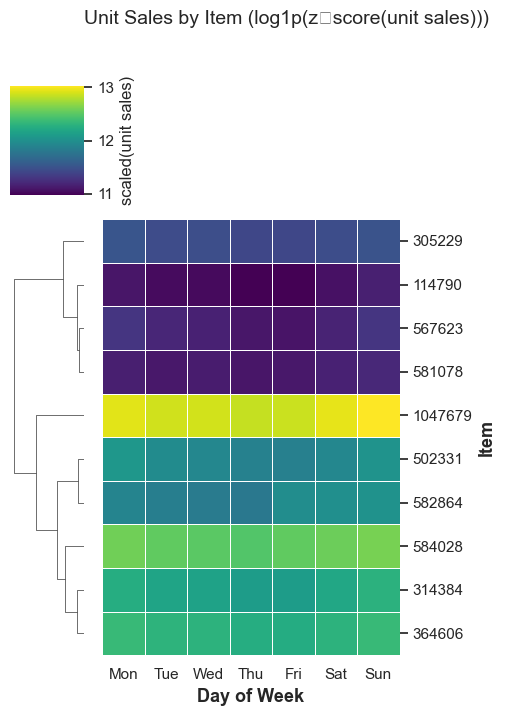

In [42]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# ---------------------------------------------------------------------
# build the clustermap
# ---------------------------------------------------------------------
grid = sns.clustermap(
    pivot_clean,
    cmap="viridis",
    row_cluster=True,
    col_cluster=False,          # keep Mon→Sun order
    linewidths=.4, linecolor="white",
    figsize=(6, 7),
  #      cbar_pos=(0.90, 0.20, 0.03, 0.65),   # [x, y, width, height]
    cbar_kws={
        "label": "scaled(unit sales)",
        "orientation": "vertical",   # just to be explicit
    }
)

# tidy up the heat‑map axis
ax = grid.ax_heatmap
ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week",  fontsize=13, fontweight="bold")
ax.set_ylabel("Item",        fontsize=13, fontweight="bold")

# overall title (use the figure, not the heat‑map axis)
grid.figure.suptitle(
    "Unit Sales by Item (log1p(z‑score(unit sales)))",
    fontsize=14, y=1.02
)


grid.cax.yaxis.tick_right()
grid.figure.tight_layout(rect=[0, 0, 0.88, 1])

# ---------------------------------------------------------------------
# save / show
# ---------------------------------------------------------------------
fn = "../output/figures/20250610_clustered_item_sales_matrix.tiff"
grid.figure.savefig(fn, dpi=300    )
plt.show()
plt.close()


In [44]:
results_spectral_clustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(2, 8),
    cv_folds=3
)
results_spectral_clustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-p

Evaluating n_row=5
Evaluating n_row=6


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:372: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning:

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,59.052952,0.502932,NaN
1,3,NaN,86.294428,0.297913,NaN
2,4,NaN,88.017222,0.482839,NaN
3,5,NaN,90.963996,0.514127,NaN
4,6,NaN,91.246928,0.514127,NaN


In [45]:
results_spectral_biclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralBiclustering,
    n_clusters_row_range=range(2, 7),  
    cv_folds=3
)
results_spectral_biclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,29.414937,0.502932,NaN
1,3,NaN,50.118215,0.585602,NaN
2,4,NaN,82.861211,0.585602,NaN
3,5,NaN,87.247744,0.236738,NaN
4,6,NaN,87.247744,0.236738,NaN


In [46]:
results_spectral_coclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralCoclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_coclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,13.132559,0.248948,NaN
1,3,NaN,29.572957,0.502932,NaN
2,4,NaN,31.210978,0.502932,NaN
3,5,NaN,79.531610,0.514127,NaN
4,6,NaN,93.000911,0.585602,NaN


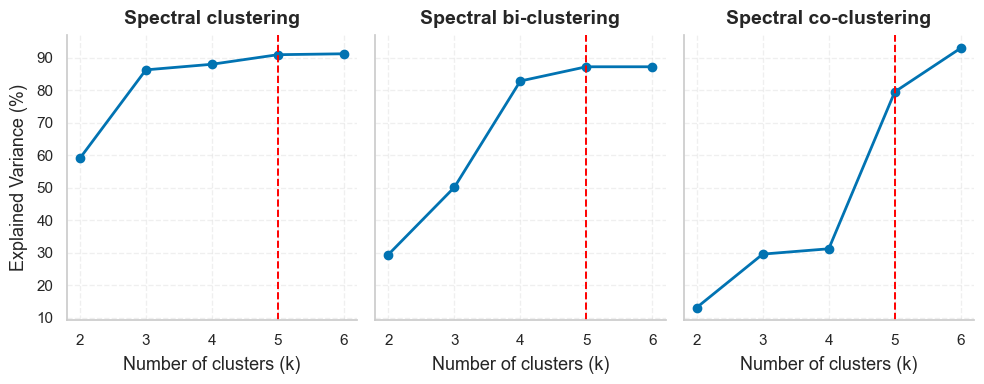

In [48]:
plot_spectral_clustering_elbows([results_spectral_clustering, results_spectral_biclustering, results_spectral_coclustering], 
                                titles=["Spectral clustering", 
                                        "Spectral bi-clustering", 
                                        "Spectral co-clustering"], 
                                vline_x=5,
                                fn="../output/figures/20250610_item_spectral_clustering_elbow.tiff")

In [49]:
item_clusters = generate_store_item_clusters(pivot_clean, n_clusters=4, model_class=SpectralClustering)
item_clusters

,store_item,clusterId
0,114790,1
1,305229,3
2,314384,2
3,364606,2
4,502331,3
5,567623,1
6,581078,1
7,582864,3
8,584028,2
9,1047679,0


In [50]:
item_clusters.to_excel("../output/data/20250610_item_clusters.xlsx", index=False)

In [ ]:
results_df = compute_gdkm_cv_scores(
    X,
    P_range=range(20, 30),   # Try 2 to 7 row clusters
    Q_range=range(20, 30),   # Try 2 to 7 column clusters
    cv_folds=3             # 3-fold CV
)

In [23]:
# With BIC-like penalty (favors simpler models)
best_pq, best_score = suggest_optimal_pq(results_df, criterion='bic', penalty_lambda=0.5)
print(f"Best (P, Q) by penalized loss: {best_pq} → score = {best_score:.3f}")

Best (P, Q) by penalized loss: (2, 4) → score = 210.768


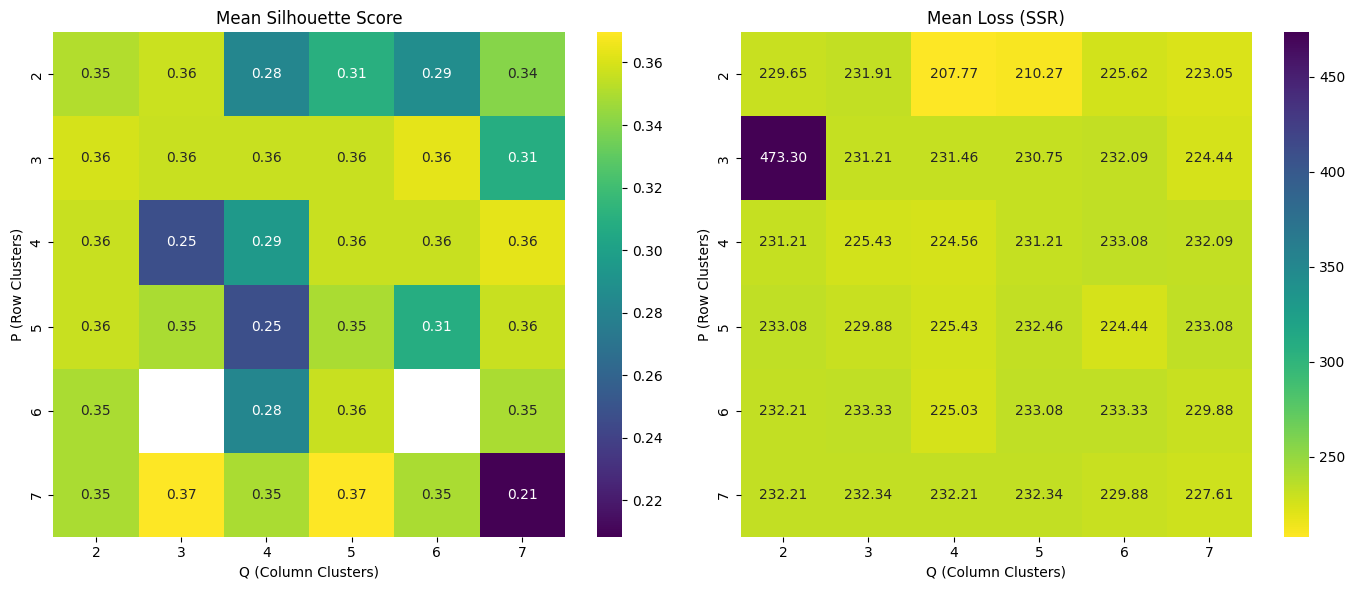

In [24]:
visualize_gdkm_cv_scores(results_df)

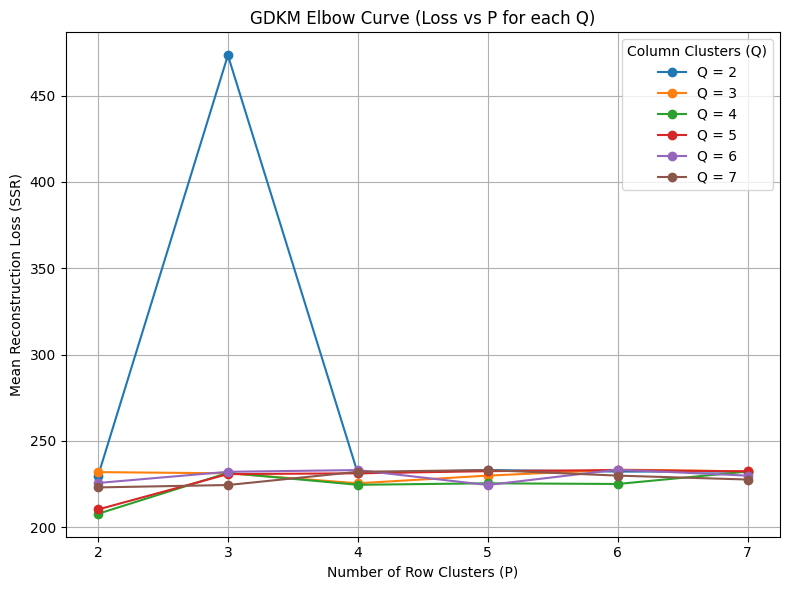

In [25]:
plot_gdkm_elbow_curve(results_df)

In [ ]:

U, V_list, C_blocks, _ = generalized_double_kmeans(
    X, P=4, Q_list=[5]*4, random_state=42
)

visualize_clustered_matrix(X, U, V_list, title="Sales Time-Series Clustering (Preprocessed)")
